# Avocado PriceAnalysisAndPrediction_Part2
## [Model defintion and deployment]
#### Avocado Prices and Sales Volume in multiple US markets (2015-2020)


## Content

[Model 1: Stateful LSTM model (FOCUS)](#Model-1:-Stateful-LSTM-model-(FOCUS))

[Model 2: Stateless LSTM model (Benchmark 1)](#Model-2:-Stateless-LSTM-model-(Benchmark-1))

[Model 3: Classical Time Series Analysis by SARIMA (Benchmark 2)](#Model-3:-Classical-Time-Series-Analysis-by-SARIMA-(Benchmark-2))


    

    

##### Input data：AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv#####
    After the Part 1 of data cleansing and some general feature creation, I created a dataset called AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv b
    The original data I used in this project is from Kaggle page (https://www.kaggle.com/alanluo418/avocado-prices-20152019). All the data was obtained from the Hass Avocado Board website in January of 2020.
    The above page refers to an earlier Kaggle page about Avocado price (https://www.kaggle.com/neuromusic/avocado-prices).





# Preprocessing data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/jingliu8876133/AvocadoData/DesignThinkingCourse/AfterCleansingFeatureCreation_AvocadoPriceUSA20152019.csv'
df = pd.read_csv(url,index_col=0)
df.head(10)

AveragePrice  Total Volume     4046      4225    4770  Total Bags  \
Date                                                                            
2015-01-04          1.22      40873.28  2819.50  28287.42   49.90     9716.46   
2015-01-11          1.24      41195.08  1002.85  31640.34  127.12     8424.77   
2015-01-18          1.17      44511.28   914.14  31540.32  135.77    11921.05   
2015-01-25          1.06      45147.50   941.38  33196.16  164.14    10845.82   
2015-02-01          0.99      70873.60  1353.90  60017.20  179.32     9323.18   
2015-02-08          0.99      51253.97  1357.37  39111.81  163.25    10621.54   
2015-02-15          1.06      41567.62   986.66  30045.51  222.42    10313.03   
2015-02-22          1.07      45675.05  1088.38  35056.13  151.00     9379.54   
2015-03-01          0.99      55595.74   629.46  45633.34  181.49     9151.45   
2015-03-08          1.07      40507.36   795.68  30370.64  159.05     9181.99   

            Small Bags  Large Bags  XLarge Bags          type  year  Month  \
Date                                                                         
2015-01-04     9186.93      529.53          0.0  conventional  2015      1   
2015-01-11     8036.04      388.73          0.0  conventional  2015      1   
2015-01-18    11651.09      269.96          0.0  conventional  2015      1   
2015-01-25    10103.35      742.47          0.0  conventional  2015      1   
2015-02-01     9170.82      152.36          0.0  conventional  2015      2   
2015-02-08    10113.10      508.44          0.0  conventional  2015      2   
2015-02-15     9979.87      333.16          0.0  conventional  2015      2   
2015-02-22     9000.16      379.38          0.0  conventional  2015      2   
2015-03-01     8986.06      165.39          0.0  conventional  2015      3   
2015-03-08     8827.55      354.44          0.0  conventional  2015      3   

            Region        lat        lon      pop  
Date                                               
2015-01-04  Albany  42.651167 -73.754968  61394.5  
2015-01-11  Albany  42.651167 -73.754968  61394.5  
2015-01-18  Albany  42.651167 -73.754968  61394.5  
2015-01-25  Albany  42.651167 -73.754968  61394.5  
2015-02-01  Albany  42.651167 -73.754968  61394.5  
2015-02-08  Albany  42.651167 -73.754968  61394.5  
2015-02-15  Albany  42.651167 -73.754968  61394.5  
2015-02-22  Albany  42.651167 -73.754968  61394.5  
2015-03-01  Albany  42.651167 -73.754968  61394.5  
2015-03-08  Albany  42.651167 -73.754968  61394.5

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21252 entries, 2015-01-04 to 2019-12-01
Data columns (total 16 columns):
AveragePrice    21252 non-null float64
Total Volume    21252 non-null float64
4046            21252 non-null float64
4225            21252 non-null float64
4770            21252 non-null float64
Total Bags      21252 non-null float64
Small Bags      21252 non-null float64
Large Bags      21252 non-null float64
XLarge Bags     21252 non-null float64
type            21252 non-null object
year            21252 non-null int64
Month           21252 non-null int64
Region          21252 non-null object
lat             14674 non-null float64
lon             14674 non-null float64
pop             14674 non-null float64
dtypes: float64(12), int64(2), object(2)
memory usage: 2.8+ MB


In [5]:
#Create conventional and organic avocado dataframes
#These will be used to analyse the region-dependent price
conventional = df[df.type =='conventional']
organic = df[df.type =='organic']

#Create mean conventional and organic avocado dataframes (average over all the regions)
#These will be used to analyse the overall price
conventional_groupByDate = conventional.groupby(conventional.index).mean()
organic_groupByDate = organic.groupby(organic.index).mean()

organic_groupByDate.head()




AveragePrice  Total Volume         4046         4225       4770  \
Date                                                                          
2015-01-04      1.590952   8973.370714  3872.599286  3292.416429  67.307143   
2015-01-11      1.631190   9970.927143  4415.711667  4020.298810  58.582381   
2015-01-18      1.650952  10376.154048  3882.991667  4813.279286  62.782857   
2015-01-25      1.681190   7816.676190  3195.160952  3058.375714  74.775952   
2015-02-01      1.530952  10987.513571  4773.649762  3946.240476  90.515952   

             Total Bags   Small Bags  Large Bags  XLarge Bags  year  Month  \
Date                                                                         
2015-01-04  1741.047857  1126.128095  614.919762          0.0  2015      1   
2015-01-11  1476.334286  1106.319286  370.015000          0.0  2015      1   
2015-01-18  1617.100238  1001.213571  615.886667          0.0  2015      1   
2015-01-25  1488.363571   963.052143  525.311429          0.0  2015      1   
2015-02-01  2177.107381  1525.291429  651.815952          0.0  2015      2   

                  lat        lon            pop  
Date                                             
2015-01-04  38.470086 -93.085705  931920.211494  
2015-01-11  38.470086 -93.085705  931920.211494  
2015-01-18  38.470086 -93.085705  931920.211494  
2015-01-25  38.470086 -93.085705  931920.211494  
2015-02-01  38.470086 -93.085705  931920.211494

In [17]:
conventional.head()

AveragePrice  Total Volume     4046      4225    4770  Total Bags  \
Date                                                                            
2015-01-04          1.22      40873.28  2819.50  28287.42   49.90     9716.46   
2015-01-11          1.24      41195.08  1002.85  31640.34  127.12     8424.77   
2015-01-18          1.17      44511.28   914.14  31540.32  135.77    11921.05   
2015-01-25          1.06      45147.50   941.38  33196.16  164.14    10845.82   
2015-02-01          0.99      70873.60  1353.90  60017.20  179.32     9323.18   

            Small Bags  Large Bags  XLarge Bags          type  year  Month  \
Date                                                                         
2015-01-04     9186.93      529.53          0.0  conventional  2015      1   
2015-01-11     8036.04      388.73          0.0  conventional  2015      1   
2015-01-18    11651.09      269.96          0.0  conventional  2015      1   
2015-01-25    10103.35      742.47          0.0  conventional  2015      1   
2015-02-01     9170.82      152.36          0.0  conventional  2015      2   

            Region        lat        lon      pop  
Date                                               
2015-01-04  Albany  42.651167 -73.754968  61394.5  
2015-01-11  Albany  42.651167 -73.754968  61394.5  
2015-01-18  Albany  42.651167 -73.754968  61394.5  
2015-01-25  Albany  42.651167 -73.754968  61394.5  
2015-02-01  Albany  42.651167 -73.754968  61394.5

## Overall price
The conventional avocado total volume is more than 10 times higher than that of organic one. 
So it is more interesting to focus on analyse the price of the conventional ones. 

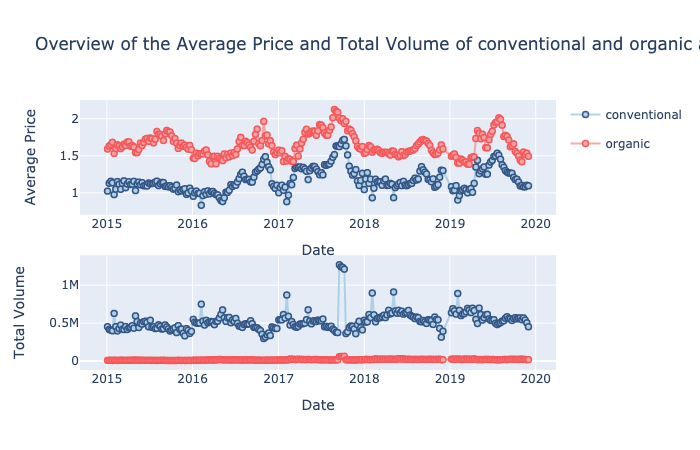

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1)


fig.append_trace(go.Scatter(
    x=conventional_groupByDate.index,y=conventional_groupByDate.AveragePrice,
                   name='conventional',legendgroup='train',mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8), row=1, col=1)

fig.append_trace(go.Scatter(
    x=organic_groupByDate.index,y=organic_groupByDate.AveragePrice,
                   name='organic',legendgroup='test',mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8), row=1, col=1)


fig.append_trace(go.Scatter(
    x=conventional_groupByDate.index,y=conventional_groupByDate['Total Volume'],
                   name='conventional',showlegend=False, mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8), row=2, col=1)

fig.append_trace(go.Scatter(
    x=organic_groupByDate.index,y=organic_groupByDate['Total Volume'],
                   name='organic',showlegend=False, mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8), row=2, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
# Update yaxis properties
fig.update_yaxes(title_text="Average Price", row=1, col=1)
fig.update_yaxes(title_text="Total Volume",  row=2, col=1)

fig.update_layout(height=700, width=1000, title_text="Overview of the Average Price and Total Volume of conventional and organic avocados"
                 )
# iplot(fig) #Makes it interactive in the notebook.
fig.show('png')#To show in output pdf.
    
    

## Region-dependent price

In [7]:
#Let's have a look what regions are there for the customerized marketing strategies.
print("Total number of regions: ",len(conventional.Region.unique()))
print(df.Region.unique())


Total number of regions:  42
['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'Charlotte' 'Chicago' 'CincinnatiDayton' 'Columbus'
 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'HarrisburgScranton'
 'HartfordSpringfield' 'Houston' 'Indianapolis' 'Jacksonville' 'LasVegas'
 'LosAngeles' 'Louisville' 'MiamiFtLauderdale' 'Nashville'
 'NewOrleansMobile' 'NewYork' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk' 'Roanoke'
 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle' 'Spokane' 'StLouis'
 'Syracuse' 'Tampa']


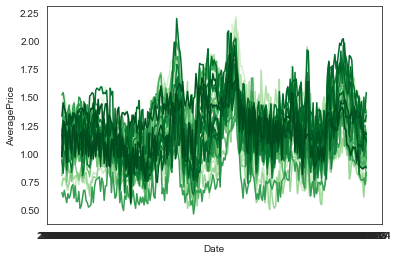

In [60]:
#The time series for conventional avocado in different regions
sns.lineplot(data = conventional, x= conventional.index, y='AveragePrice', hue='Region', palette = 'Greens',legend=False)

In [18]:
#Here I use string (region name) as a variable name by using a dictionary
#We can create time series for each individual region
region_ts = {}
for region in df.Region.unique():
    region_ts[region] = conventional[conventional.Region==region]['AveragePrice']
    region_ts[region] = region_ts[region].to_frame()

# Model deployment

## Applying autoregression to the overall price for conventional avocado

In [ ]:
conventional_groupByDate.head()
#The data were taken on every sunday.

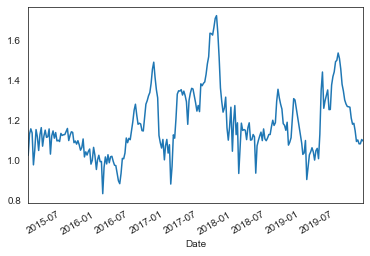

In [22]:
#Let's have a quick look at the time series of the averageprice we want to predict. It is a weekly frequency data.
conventional_AveragePrice = conventional_groupByDate['AveragePrice']
conventional_AveragePrice.plot()

In [28]:
 #conventional_AveragePrice.to_frame().values
df = conventional_AveragePrice.copy()
df = df.to_frame()
df.head()

AveragePrice
Date                    
2015-01-04      1.023095
2015-01-11      1.129286
2015-01-18      1.155714
2015-01-25      1.135238
2015-02-01      0.976190

### Exploration

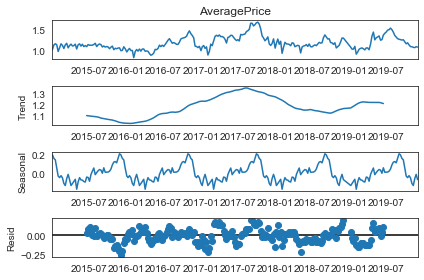

In [214]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df['AveragePrice'], model='additive',period=48)
x = decomposed.plot() #See note below about this

In [25]:
# create lagged dataset
values = DataFrame(df.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.907343
t+1  0.907343  1.000000


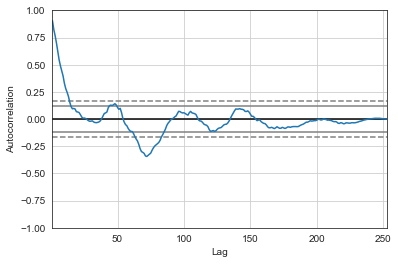

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df)
pyplot.show()

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

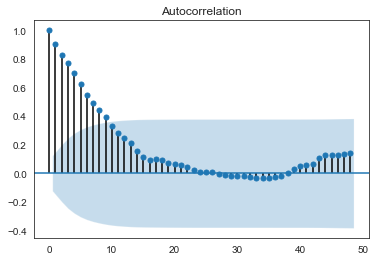

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=48)
pyplot.show()

### Autoregression Model

Coefficients: [0.1087444 0.9082185]
Coefficients: [0.1064432  0.89155838 0.01854626]
Coefficients: [ 0.09547362  0.89003485 -0.07515389  0.10467842]
Coefficients: [ 0.10612441  0.89599372 -0.07573954  0.17851776 -0.08774981]
Coefficients: [ 0.11012061  0.89851546 -0.07183127  0.17334748 -0.0431607  -0.04946393]
Coefficients: [ 0.11760772  0.89098554 -0.06040411  0.17897187 -0.05043207  0.02248087
 -0.08094893]
Coefficients: [ 0.10944626  0.89770557 -0.06240876  0.17884431 -0.06156126  0.02766102
 -0.13883749  0.06634127]
Coefficients: [ 0.10681407  0.89463864 -0.05227754  0.17632855 -0.07164555  0.02827187
 -0.13510626  0.03988674  0.0301823 ]
Coefficients: [ 0.10315024  0.89779675 -0.0554656   0.17398901 -0.07134943  0.04033745
 -0.14513938  0.04048702  0.01286273  0.01967879]
Best lag number is:  6


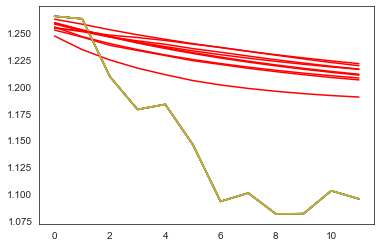

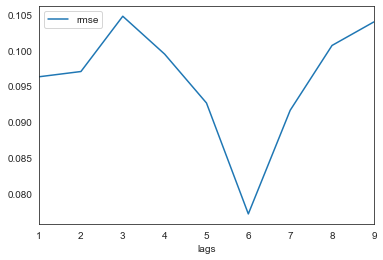

In [41]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# # load dataset
# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset

X = df.values
train, test = X[1:len(X)-12], X[len(X)-12:]
# Find the best lag
# train autoregression
cols = ['lags', 'rmse']
lst = []
#10 is chosen based on plt_pcf
for lag in range(1,10):
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    rmse = sqrt(mean_squared_error(test, predictions))
    lst.append([lag, rmse])

    # plot results
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
#     pyplot.show()
best_lag_num = pd.DataFrame(lst, columns=cols)
best_lag_num.plot(x='lags',y='rmse')
best_lag = best_lag_num[best_lag_num.rmse==best_lag_num.rmse.min()].lags.values[0]
print('Best lag number is: ',best_lag)

Coefficients: [ 0.11760772  0.89098554 -0.06040411  0.17897187 -0.05043207  0.02248087
 -0.08094893]
Test RMSE: 0.104
Number of lags: 6


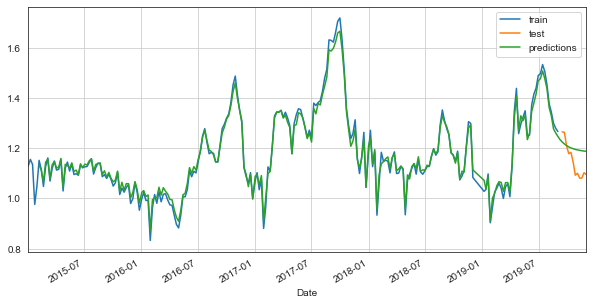

In [35]:
# # make predictions only for the testset part
# predictions = model_fit.predict(start=len(train, end=len(train)+len(test)-1, dynamic=False)
# make predictions beyond the testset.
model = AutoReg(train, lags=best_lag)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
rmse = sqrt(mean_squared_error(test, predictions))
predictions = model_fit.predict(start=0, end=len(df), dynamic=False)
print('Test RMSE: %.3f' % rmse)
print('Number of lags: %.0f' % len(model_fit.ar_lags))
# plot results

#Make a dataframe for the results of the predictions
pred_result_df=df.copy()
#Prediction column
pred_result_df.loc[-predictions.shape[0]:,'predictions']=predictions
#Train column
pred_result_df.loc[:train.shape[0],'train']=train.reshape(1,-1)
#Test column
pred_result_df.loc[-test.shape[0]:,'test']=test.reshape(1,-1)
pred_result_df.plot(y=['train', 'test','predictions'],figsize=(10,5), grid=True)

## Applying autoregression to the conventional avocado price in different region
We will repeat the above autoregression process to time series for different regions. Eventually I want to cluster the time series based on the autoregression coefficients. In order achieve this, we can make a function to find the best lag for each time series and then we decide on one.

In [36]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
def find_the_best_lag_for_ts (df):
    X = df.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    # Find the best lag
    # train autoregression
    cols = ['lags', 'rmse']
    lst = []
    for lag in range(1,10):
        model = AutoReg(train, lags=lag)
        model_fit = model.fit()
        #print('Coefficients: %s' % model_fit.params)
        # make predictions
        predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        rmse = sqrt(mean_squared_error(test, predictions))
        lst.append([lag, rmse])
    #     pyplot.show()
    best_lag_num = pd.DataFrame(lst, columns=cols)
    #best_lag_num.plot(x='lags',y='rmse')
    best_lag = best_lag_num[best_lag_num.rmse==best_lag_num.rmse.min()].lags.values[0]
    rmse_of_best_lag = best_lag_num[best_lag_num.rmse==best_lag_num.rmse.min()].rmse.values[0]
    return best_lag, rmse_of_best_lag


In [37]:
#Here I use string (region name) as a variable name by using a dictionary
#Let's create the time series for each individual region
cols = ['region','best_lag', 'rmse_of_best_lag']
lst = []

region_ts = {}
for region in conventional.Region.unique():
    region_ts[region] = conventional[conventional.Region==region]['AveragePrice']
    region_ts[region] = region_ts[region].to_frame()
    best_lag = find_the_best_lag_for_ts(region_ts[region])[0]
    rmse_of_best_lag = find_the_best_lag_for_ts(region_ts[region])[1]
    lst.append([region, best_lag, rmse_of_best_lag])
region_best_lag = pd.DataFrame(lst, columns=cols)
region_best_lag

region  best_lag  rmse_of_best_lag
0                Albany         1          0.160884
1               Atlanta         7          0.081334
2   BaltimoreWashington         4          0.187591
3                 Boise         1          0.083086
4                Boston         1          0.067907
5      BuffaloRochester         3          0.053811
6             Charlotte         1          0.107766
7               Chicago         2          0.248220
8      CincinnatiDayton         4          0.127924
9              Columbus         8          0.097385
10        DallasFtWorth         1          0.058972
11               Denver         1          0.074115
12              Detroit         3          0.109742
13          GrandRapids         4          0.134037
14   HarrisburgScranton         8          0.090763
15  HartfordSpringfield         9          0.168950
16              Houston         8          0.078135
17         Indianapolis         9          0.083136
18         Jacksonville         8          0.174821
19             LasVegas         3          0.085123
20           LosAngeles         3          0.213179
21           Louisville         9          0.142300
22    MiamiFtLauderdale         4          0.149339
23            Nashville         7          0.089338
24     NewOrleansMobile         3          0.110684
25              NewYork         9          0.178988
26              Orlando         4          0.175320
27         Philadelphia         9          0.127829
28        PhoenixTucson         1          0.192820
29           Pittsburgh         7          0.146115
30             Portland         1          0.065523
31    RaleighGreensboro         6          0.197509
32      RichmondNorfolk         4          0.089990
33              Roanoke         4          0.087645
34           Sacramento         1          0.140121
35             SanDiego         3          0.219655
36         SanFrancisco         8          0.269900
37              Seattle         1          0.095899
38              Spokane         1          0.071206
39              StLouis         2          0.093611
40             Syracuse         1          0.118131
41                Tampa         3          0.191524

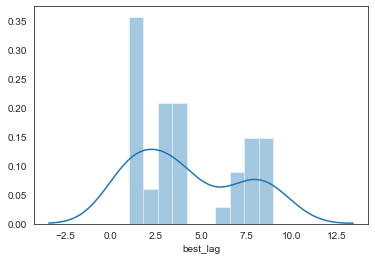

In [39]:
sns.distplot(region_best_lag.best_lag,bins=10)

Let's use 7 as the lag number for all the autoregression for different time series.

In [42]:


def autoregression (ts,lag):
    X = ts.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    # train autoregression
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    #print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    rmse = sqrt(mean_squared_error(test, predictions))
    return model_fit.params,  rmse

In [47]:
autoregression(region_ts['NewYork'],lag=lag)[0][0]

0.1869975717310193

In [72]:
#Here I use string (region name) as a variable name by using a dictionary
#Let's create the time series for each individual region
cols = ['Region','coefficient0','coefficient1','coefficient2','coefficient3','coefficient4','coefficient5' ,'coefficient6','coefficient7','rmse']
lst = []

lag=7

region_ts = {}
for region in conventional.Region.unique():
    region_ts[region] = conventional[conventional.Region==region]['AveragePrice']
    region_ts[region] = region_ts[region].to_frame()
    rmse = autoregression(region_ts[region],lag=lag)[1]
    auto_coef={}
    for i in range(0,8):
        auto_coef[i] = autoregression(region_ts[region],lag=lag)[0][i]
    lst.append([region, auto_coef[0],auto_coef[1],auto_coef[2], auto_coef[3],auto_coef[4],auto_coef[5],auto_coef[6],auto_coef[7],rmse])
region_autoreg_coef = pd.DataFrame(lst, columns=cols)
region_autoreg_coef

Region  coefficient0  coefficient1  coefficient2  \
0                Albany      0.262523      0.236748      0.031686   
1               Atlanta      0.139876      0.672549      0.228641   
2   BaltimoreWashington      0.171814      0.524244      0.125314   
3                 Boise      0.069309      0.652884      0.045280   
4                Boston      0.126959      0.585711      0.146357   
5      BuffaloRochester      0.148723      0.811232      0.104842   
6             Charlotte      0.151309      0.547893      0.373935   
7               Chicago      0.180117      0.791969     -0.084342   
8      CincinnatiDayton      0.136397      0.857139     -0.077553   
9              Columbus      0.244683      0.851664     -0.347879   
10        DallasFtWorth      0.104350      0.871420      0.144848   
11               Denver      0.149619      0.727159     -0.087275   
12              Detroit      0.282928      0.648040      0.025881   
13          GrandRapids      0.245668      0.175381      0.371411   
14   HarrisburgScranton      0.096380      0.789342     -0.075671   
15  HartfordSpringfield      0.216748      0.487204      0.070366   
16              Houston      0.135496      0.805810     -0.048008   
17         Indianapolis      0.174132      0.839761     -0.153826   
18         Jacksonville      0.201737      0.356131      0.342549   
19             LasVegas      0.144983      0.796437     -0.005192   
20           LosAngeles      0.122887      0.915224     -0.126947   
21           Louisville      0.156622      0.869309     -0.267878   
22    MiamiFtLauderdale      0.226373      0.287766      0.376215   
23            Nashville      0.199049      0.748727     -0.023215   
24     NewOrleansMobile      0.136347      0.662119      0.142315   
25              NewYork      0.186998      0.557313      0.221376   
26              Orlando      0.203737      0.291806      0.371028   
27         Philadelphia      0.141282      0.677979      0.091365   
28        PhoenixTucson      0.094321      0.723580      0.231524   
29           Pittsburgh      0.448509      0.381036      0.223606   
30             Portland      0.113505      0.488849      0.169877   
31    RaleighGreensboro      0.209358      0.488595      0.243160   
32      RichmondNorfolk      0.175321      0.662487     -0.044636   
33              Roanoke      0.157267      0.843303     -0.182029   
34           Sacramento      0.168734      0.627118      0.145983   
35             SanDiego      0.156172      0.767009     -0.050023   
36         SanFrancisco      0.338721      0.418243      0.284812   
37              Seattle      0.076410      0.521036      0.105972   
38              Spokane      0.099280      0.622672      0.010655   
39              StLouis      0.154773      0.620793     -0.017333   
40             Syracuse      0.184029      0.574564      0.044514   
41                Tampa      0.186620      0.333880      0.384774   

    coefficient3  coefficient4  coefficient5  coefficient6  coefficient7  \
0       0.127885      0.255297      0.074542     -0.010712      0.092119   
1      -0.008734      0.099004     -0.048702     -0.060305     -0.014637   
2       0.169092      0.097359     -0.057421      0.002197      0.014278   
3       0.186960      0.032888      0.014374     -0.019698      0.030055   
4       0.131988      0.003356      0.039313     -0.003294      0.002448   
5      -0.094528     -0.035992      0.145600     -0.076717      0.034338   
6       0.071259     -0.209805      0.013211      0.135676     -0.049598   
7       0.128946      0.049654      0.057794     -0.044743     -0.029183   
8       0.096348      0.010262     -0.059277     -0.064552      0.107044   
9       0.358004     -0.130340      0.044769      0.043960     -0.052572   
10      0.028308     -0.225826      0.031718      0.030246     -0.002992   
11      0.317890     -0.112658      0.079753     -0.160764      0.102683   
12      0.296299     -0.091465     -0.095133     -0.076600   

### Cluster regions based on the coefficients and rmse of the Autoregression

In [102]:
#Pick up the feature columns
region_autoreg_coef_f = region_autoreg_coef[['coefficient0', 'coefficient1', 'coefficient2',
       'coefficient3', 'coefficient4', 'coefficient5', 'coefficient6',
       'coefficient7', 'rmse']]

In [103]:
from sklearn.preprocessing import MinMaxScaler

In [104]:
scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(region_autoreg_coef_f)

region_autoreg_coef_f = scaler.transform(region_autoreg_coef_f)

In [105]:
from sklearn.cluster import KMeans

In [106]:
kmeans = KMeans(n_clusters=3)

In [107]:
kmeans.fit(region_autoreg_coef_f)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [108]:
kmeans.cluster_centers_

array([[0.27690184, 0.62277906, 0.68017968, 0.34205553, 0.41580067,
        0.63687402, 0.67894703, 0.29168992, 0.26405267],
       [0.22624173, 0.81386478, 0.34946786, 0.66699927, 0.46983966,
        0.5585994 , 0.42461239, 0.44439123, 0.32596384],
       [0.34424003, 0.29976923, 0.79665687, 0.53242472, 0.6716235 ,
        0.42617981, 0.45051924, 0.59654665, 0.52289679]])

In [111]:
region_autoreg_coef_melt=region_autoreg_coef.melt(id_vars=['Region'])
region_autoreg_coef_melt

Region      variable     value
0                 Albany  coefficient0  0.262523
1                Atlanta  coefficient0  0.139876
2    BaltimoreWashington  coefficient0  0.171814
3                  Boise  coefficient0  0.069309
4                 Boston  coefficient0  0.126959
..                   ...           ...       ...
373              Seattle          rmse  0.321283
374              Spokane          rmse  0.196606
375              StLouis          rmse  0.103534
376             Syracuse          rmse  0.125461
377                Tampa          rmse  0.192777

[378 rows x 3 columns]

In [119]:
region_autoreg_coef['kmean_cluster3']=pd.Series(kmeans.labels_).values
region_autoreg_coef.head()

Region  coefficient0  coefficient1  coefficient2  \
0               Albany      0.262523      0.236748      0.031686   
1              Atlanta      0.139876      0.672549      0.228641   
2  BaltimoreWashington      0.171814      0.524244      0.125314   
3                Boise      0.069309      0.652884      0.045280   
4               Boston      0.126959      0.585711      0.146357   

   coefficient3  coefficient4  coefficient5  coefficient6  coefficient7  \
0      0.127885      0.255297      0.074542     -0.010712      0.092119   
1     -0.008734      0.099004     -0.048702     -0.060305     -0.014637   
2      0.169092      0.097359     -0.057421      0.002197      0.014278   
3      0.186960      0.032888      0.014374     -0.019698      0.030055   
4      0.131988      0.003356      0.039313     -0.003294      0.002448   

       rmse  kmean_cluster3  
0  0.189110               2  
1  0.081334               0  
2  0.191881               2  
3  0.205263               1  
4  0.102363               0

In [120]:
region_autoreg_coef.index=region_autoreg_coef.Region

In [125]:
#Create a dictionary from the region and cluster results
kmeancluester3_dic = pd.Series(region_autoreg_coef.kmean_cluster3.values,index = region_autoreg_coef.Region).to_dict()

In [126]:
kmeancluester3_dic

{'Albany': 2,
 'Atlanta': 0,
 'BaltimoreWashington': 2,
 'Boise': 1,
 'Boston': 0,
 'BuffaloRochester': 0,
 'Charlotte': 0,
 'Chicago': 1,
 'CincinnatiDayton': 1,
 'Columbus': 1,
 'DallasFtWorth': 0,
 'Denver': 1,
 'Detroit': 1,
 'GrandRapids': 2,
 'HarrisburgScranton': 1,
 'HartfordSpringfield': 0,
 'Houston': 1,
 'Indianapolis': 1,
 'Jacksonville': 2,
 'LasVegas': 1,
 'LosAngeles': 1,
 'Louisville': 1,
 'MiamiFtLauderdale': 2,
 'Nashville': 0,
 'NewOrleansMobile': 0,
 'NewYork': 2,
 'Orlando': 2,
 'Philadelphia': 0,
 'PhoenixTucson': 0,
 'Pittsburgh': 0,
 'Portland': 2,
 'RaleighGreensboro': 0,
 'RichmondNorfolk': 1,
 'Roanoke': 1,
 'Sacramento': 0,
 'SanDiego': 1,
 'SanFrancisco': 2,
 'Seattle': 2,
 'Spokane': 1,
 'StLouis': 0,
 'Syracuse': 2,
 'Tampa': 2}

In [127]:
region_autoreg_coef_melt['kmean_cluster3'] = region_autoreg_coef_melt['kmean_cluster3'].map(kmeancluester3_dic)
region_autoreg_coef_melt.head()

Region      variable     value  kmean_cluster3
0               Albany  coefficient0  0.262523               2
1              Atlanta  coefficient0  0.139876               0
2  BaltimoreWashington  coefficient0  0.171814               2
3                Boise  coefficient0  0.069309               1
4               Boston  coefficient0  0.126959               0

In [147]:
region_autoreg_coef_melt

Region      variable     value  kmean_cluster3
0                 Albany  coefficient0  0.262523               2
1                Atlanta  coefficient0  0.139876               0
2    BaltimoreWashington  coefficient0  0.171814               2
3                  Boise  coefficient0  0.069309               1
4                 Boston  coefficient0  0.126959               0
..                   ...           ...       ...             ...
373              Seattle          rmse  0.321283               2
374              Spokane          rmse  0.196606               1
375              StLouis          rmse  0.103534               0
376             Syracuse          rmse  0.125461               2
377                Tampa          rmse  0.192777               2

[378 rows x 4 columns]

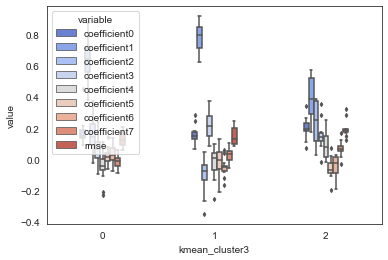

In [152]:
sns.boxplot(x='kmean_cluster3',y='value',data=region_autoreg_coef_melt,hue='variable',fliersize=3,
           palette ='coolwarm',
           saturation=0.75,
           width=0.4,
           
           )

In [132]:
import plotly.express as px
fig = px.scatter(region_autoreg_coef_melt, x='variable', y='value',
                    color='kmean_cluster3', color_discrete_sequence=['r','y','b'],opacity=0.7, width=800,
    height=800,hover_data=[region_autoreg_coef_melt['Region']])
fig.show()

In [ ]:
plt.style.use('seaborn-darkgrid')


colormap={0.0:'r',1.0:'g',2.0:'b'}



i=0
for i in np.arange(0,len(dfnorm['Country'].unique())):
    country= dfnorm['Country'].unique()[i]
    dfcountry= dfnorm[dfnorm['Country']==country]
    c=colormap[dfnorm[dfnorm['Country']==country]['kmean_cluster3'].mean()]
    plt.plot('variable', 'value', data=dfcountry, color=c)


# Add legend
#plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Parallel Parameters", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Variables")
plt.ylabel("Normalized Scores")


In [155]:
from sklearn.decomposition import PCA

In [156]:
pca = PCA(n_components=2)

In [157]:
pca.fit(region_autoreg_coef_f)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [158]:
len(pca.components_)

2

In [159]:
print('Explained Variance Ratio = ', sum(pca.explained_variance_ratio_[:2]))

Explained Variance Ratio =  0.5379314926148404


In [160]:
x_pca = pca.transform(region_autoreg_coef_f)

In [168]:
x_pca.shape

(42, 2)

In [165]:
region_autoreg_coef['PCA1']=pd.Series(x_pca[:,0]).values
region_autoreg_coef['PCA2']=pd.Series(x_pca[:,1]).values

In [174]:
region_autoreg_coef.head()

Region  coefficient0  coefficient1  \
Region                                                                 
Albany                            Albany      0.262523      0.236748   
Atlanta                          Atlanta      0.139876      0.672549   
BaltimoreWashington  BaltimoreWashington      0.171814      0.524244   
Boise                              Boise      0.069309      0.652884   
Boston                            Boston      0.126959      0.585711   

                     coefficient2  coefficient3  coefficient4  coefficient5  \
Region                                                                        
Albany                   0.031686      0.127885      0.255297      0.074542   
Atlanta                  0.228641     -0.008734      0.099004     -0.048702   
BaltimoreWashington      0.125314      0.169092      0.097359     -0.057421   
Boise                    0.045280      0.186960      0.032888      0.014374   
Boston                   0.146357      0.131988      0.003356      0.039313   

                     coefficient6  coefficient7      rmse  kmean_cluster3  \
Region                                                                      
Albany                  -0.010712      0.092119  0.189110               2   
Atlanta                 -0.060305     -0.014637  0.081334               0   
BaltimoreWashington      0.002197      0.014278  0.191881               2   
Boise                   -0.019698      0.030055  0.205263               1   
Boston                  -0.003294      0.002448  0.102363               0   

                         PCA1      PCA2  
Region                                   
Albany               0.499733 -0.170046  
Atlanta              0.028973  0.173125  
BaltimoreWashington  0.222473 -0.055651  
Boise               -0.057727 -0.119214  
Boston              -0.051147  0.170173

In [173]:
region_autoreg_coef_comp = pd.DataFrame(pca.components_,columns = ['coefficient0', 'coefficient1', 'coefficient2',
       'coefficient3', 'coefficient4', 'coefficient5', 'coefficient6',
       'coefficient7', 'rmse'])

In [175]:
region_autoreg_coef_comp.head()

coefficient0  coefficient1  coefficient2  coefficient3  coefficient4  \
0      0.193457     -0.651558      0.546290     -0.095602      0.245619   
1      0.140207     -0.021850      0.292798     -0.465953     -0.317082   

   coefficient5  coefficient6  coefficient7      rmse  
0     -0.215017      0.026541      0.155455  0.314711  
1      0.282267      0.488112     -0.488626 -0.140702

In [210]:
from __future__ import division
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
from bubbly.bubbly import bubbleplot


fig = bubbleplot(dataset=region_autoreg_coef, x_column='PCA1', y_column='PCA2',
    bubble_column='Region', #size_column='population', 
    color_column='kmean_cluster3', x_title="PCA1 ({:2.1f}%)".format(pca.explained_variance_ratio_[0]*100), y_title="PCA2 ({:2.1f}%)".format(pca.explained_variance_ratio_[1]*100), title='PCA plot',
    x_logscale=False, scale_bubble=1, height=600,width=600,x_range=[-1.5,1.5],y_range=[-0.5,0.8])

iplot(fig, config={'scrollzoom': True})


/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:159: UserWarning:


Unrecognized config options supplied: ['scrollzoom']



In [171]:
region_autoreg_coef.columns

Index(['Region', 'coefficient0', 'coefficient1', 'coefficient2',
       'coefficient3', 'coefficient4', 'coefficient5', 'coefficient6',
       'coefficient7', 'rmse', 'kmean_cluster3', 'PCA1', 'PCA2'],
      dtype='object')

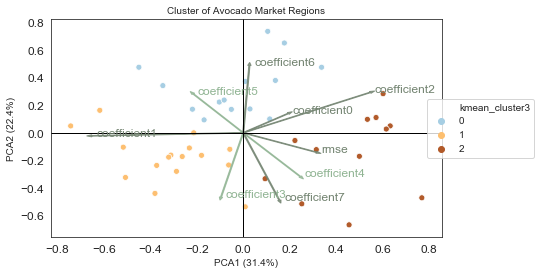

In [208]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x="PCA1", y="PCA2",
                     hue='kmean_cluster3',palette='Paired',
                     data=region_autoreg_coef, alpha=0.99,ax=ax)
ax.axhline(y=0, color='k', linewidth=1)  # added because i want the origin
ax.axvline(x=0, color='k', linewidth=1)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
#sns.lineplot(x=[0,df2019_comp['GDP'].iloc[0]], y=[0,df2019_comp['GDP'].iloc[1]], markers=True, style=None,ax=ax)
#sns.lineplot(x=[0,df2019_comp['Social support'].iloc[0]], y=[0,df2019_comp['Social support'].iloc[1]], ax=ax)
#sns.lineplot(x=[0,df2019_comp['Healthy life expectance'].iloc[0]], y=[0,df2019_comp['Healthy life expectance'].iloc[1]], ax=ax)
#sns.lineplot(x=[0,df2019_comp['Freedom'].iloc[0]], y=[0,df2019_comp['Freedom'].iloc[1]], ax=ax)
#sns.lineplot(x=[0,df2019_comp['Generosity'].iloc[0]], y=[0,df2019_comp['Generosity'].iloc[1]],ax=ax)
#sns.lineplot(x=[0,df2019_comp['Trust (Government Corruption)'].iloc[0]], y=[0,df2019_comp['Trust (Government Corruption)'].iloc[1]], ax=ax)
i=0
color=['#728370','#728370','#728370','#90B493','#90B493','#90B493','#728370','#728370','#728370']
for var in ['coefficient0', 'coefficient1', 'coefficient2',
       'coefficient3', 'coefficient4', 'coefficient5', 'coefficient6',
       'coefficient7', 'rmse']:
    ax.arrow(x=0, y=0, dx=region_autoreg_coef_comp[var].iloc[0], dy=region_autoreg_coef_comp[var].iloc[1],color=color[i],width=0.005,alpha=0.8)
    ax.text(region_autoreg_coef_comp[var].iloc[0]+0.02, region_autoreg_coef_comp[var].iloc[1], var, color=color[i],size=12)
    i=i+1
    
#ax.axis('equal')


ax.axes.set_title("Cluster of Avocado Market Regions",fontsize=10)
ax.set_xlabel("PCA1 ({:2.1f}%)".format(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel("PCA2 ({:2.1f}%)".format(pca.explained_variance_ratio_[1]*100),fontsize=10)
ax.tick_params(labelsize=12)


#ax.set_xlim(0, 2)
#ax.set_ylim(-6, 6)



In [91]:
conventional['date']=conventional.index
conventional.head()

AveragePrice  Total Volume     4046      4225    4770  Total Bags  \
Date                                                                            
2015-01-04          1.22      40873.28  2819.50  28287.42   49.90     9716.46   
2015-01-11          1.24      41195.08  1002.85  31640.34  127.12     8424.77   
2015-01-18          1.17      44511.28   914.14  31540.32  135.77    11921.05   
2015-01-25          1.06      45147.50   941.38  33196.16  164.14    10845.82   
2015-02-01          0.99      70873.60  1353.90  60017.20  179.32     9323.18   

            Small Bags  Large Bags  XLarge Bags          type  year  Month  \
Date                                                                         
2015-01-04     9186.93      529.53          0.0  conventional  2015      1   
2015-01-11     8036.04      388.73          0.0  conventional  2015      1   
2015-01-18    11651.09      269.96          0.0  conventional  2015      1   
2015-01-25    10103.35      742.47          0.0  conventional  2015      1   
2015-02-01     9170.82      152.36          0.0  conventional  2015      2   

            Region        lat        lon      pop        date  
Date                                                           
2015-01-04  Albany  42.651167 -73.754968  61394.5  2015-01-04  
2015-01-11  Albany  42.651167 -73.754968  61394.5  2015-01-11  
2015-01-18  Albany  42.651167 -73.754968  61394.5  2015-01-18  
2015-01-25  Albany  42.651167 -73.754968  61394.5  2015-01-25  
2015-02-01  Albany  42.651167 -73.754968  61394.5  2015-02-01

In [93]:
conventional_cluster= pd.merge(conventional, region_autoreg_coef[['Region','kmean_cluster3']], how='left', on=['Region'])
conventional_cluster.head()

AveragePrice  Total Volume     4046      4225    4770  Total Bags  \
0          1.22      40873.28  2819.50  28287.42   49.90     9716.46   
1          1.24      41195.08  1002.85  31640.34  127.12     8424.77   
2          1.17      44511.28   914.14  31540.32  135.77    11921.05   
3          1.06      45147.50   941.38  33196.16  164.14    10845.82   
4          0.99      70873.60  1353.90  60017.20  179.32     9323.18   

   Small Bags  Large Bags  XLarge Bags          type  year  Month  Region  \
0     9186.93      529.53          0.0  conventional  2015      1  Albany   
1     8036.04      388.73          0.0  conventional  2015      1  Albany   
2    11651.09      269.96          0.0  conventional  2015      1  Albany   
3    10103.35      742.47          0.0  conventional  2015      1  Albany   
4     9170.82      152.36          0.0  conventional  2015      2  Albany   

         lat        lon      pop        date  kmean_cluster3  
0  42.651167 -73.754968  61394.5  2015-01-04               2  
1  42.651167 -73.754968  61394.5  2015-01-11               2  
2  42.651167 -73.754968  61394.5  2015-01-18               2  
3  42.651167 -73.754968  61394.5  2015-01-25               2  
4  42.651167 -73.754968  61394.5  2015-02-01               2

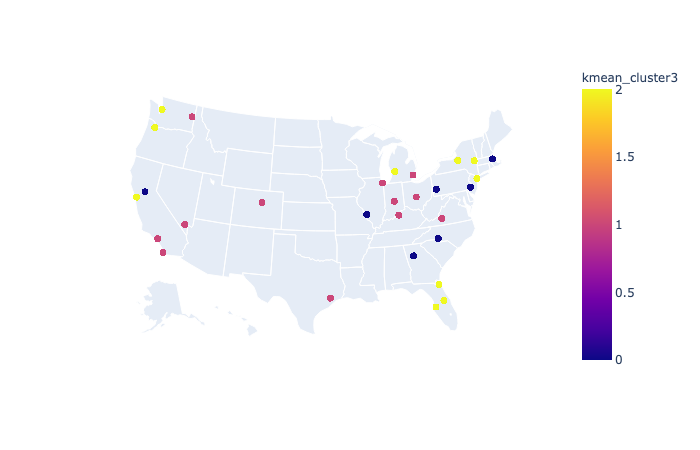

In [138]:
import plotly.graph_objects as go
import plotly.express as px




fig = px.scatter_geo(conventional_cluster, 
                     #locationmode = 'USA-states',
                     lon = 'lon',
                     lat = 'lat', 
                     color="kmean_cluster3",
                     hover_name="Region", 
                     projection = "albers usa",
                     scope="usa"
                    )



# iplot(fig) #Makes it interactive in the notebook.
fig.show('png')#To show in output pdf.


In [95]:
# conventional_cluster.index = conventional_cluster['date']
conventional_cluster.head()

AveragePrice  Total Volume     4046      4225    4770  Total Bags  \
date                                                                            
2015-01-04          1.22      40873.28  2819.50  28287.42   49.90     9716.46   
2015-01-11          1.24      41195.08  1002.85  31640.34  127.12     8424.77   
2015-01-18          1.17      44511.28   914.14  31540.32  135.77    11921.05   
2015-01-25          1.06      45147.50   941.38  33196.16  164.14    10845.82   
2015-02-01          0.99      70873.60  1353.90  60017.20  179.32     9323.18   

            Small Bags  Large Bags  XLarge Bags          type  year  Month  \
date                                                                         
2015-01-04     9186.93      529.53          0.0  conventional  2015      1   
2015-01-11     8036.04      388.73          0.0  conventional  2015      1   
2015-01-18    11651.09      269.96          0.0  conventional  2015      1   
2015-01-25    10103.35      742.47          0.0  conventional  2015      1   
2015-02-01     9170.82      152.36          0.0  conventional  2015      2   

            Region        lat        lon      pop        date  kmean_cluster3  
date                                                                           
2015-01-04  Albany  42.651167 -73.754968  61394.5  2015-01-04               2  
2015-01-11  Albany  42.651167 -73.754968  61394.5  2015-01-11               2  
2015-01-18  Albany  42.651167 -73.754968  61394.5  2015-01-18               2  
2015-01-25  Albany  42.651167 -73.754968  61394.5  2015-01-25               2  
2015-02-01  Albany  42.651167 -73.754968  61394.5  2015-02-01               2

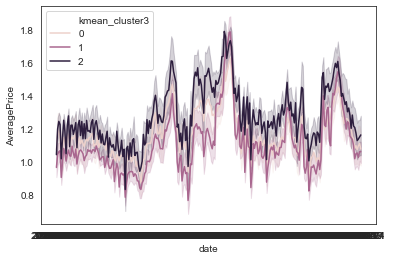

In [134]:
sns.lineplot(data = conventional_cluster, x= conventional_cluster.index, y='AveragePrice', hue='kmean_cluster3', markers='Region',legend='brief')

# Model 3: Classical Time Series Analysis by SARIMA (Benchmark 2)

Here we are going to employ a widely used time series analysis Autoregressive Integrated Moving Average (ARIMA) as the second benchmark, precisely SARIMA. S stands for Seasonal. On top of ARIMA, SARIMA can surport data with not only trend but also seasonal components. 

Refer to: https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/.

In [233]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Prepare data for SARIMA

In [234]:
df = conventional_groupByDate.copy()
df.head()

AveragePrice   Total Volume           4046           4225  \
Date                                                                    
2015-01-04      1.021719  372397.583437  135844.061562  169849.761563   
2015-01-11      1.133906  333583.128906  122830.545156  143594.668750   
2015-01-18      1.161406  323254.015156  124008.136094  133179.913438   
2015-01-25      1.137500  319078.954687  123813.233906  125616.058594   
2015-02-01      0.972656  515223.592344  202577.815156  229125.203594   

                    4770    Total Bags    Small Bags    Large Bags  \
Date                                                                 
2015-01-04  11108.452188  55595.308125  43913.780937  11446.961563   
2015-01-11  11400.261719  55757.653281  46611.036250   8951.464687   
2015-01-18   9913.391250  56152.574375  46423.023437   9634.755156   
2015-01-25   9754.899844  59894.762344  49190.856250  10602.827344   
2015-02-01  17503.426094  66017.147500  51127.177656  14110.095938   

            XLarge Bags  year  Month            pop        lat        lon  
Date                                                                       
2015-01-04   234.565625  2015      1  612212.196078  38.546966 -90.940838  
2015-01-11   195.152344  2015      1  612212.196078  38.546966 -90.940838  
2015-01-18    94.795781  2015      1  612212.196078  38.546966 -90.940838  
2015-01-25   101.078750  2015      1  612212.196078  38.546966 -90.940838  
2015-02-01   779.873906  2015      2  612212.196078  38.546966 -90.940838

In [235]:
df.index = pd.to_datetime(df.index)

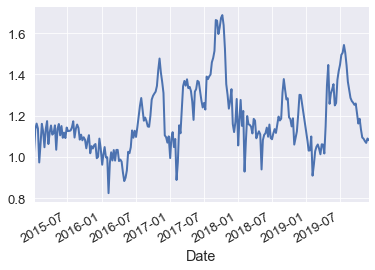

In [236]:
df['AveragePrice'].plot()

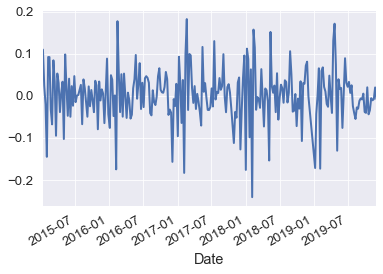

In [237]:
df['AveragePrice'].pct_change().plot()

In [238]:
prices = df['AveragePrice']

In [239]:
prices.index

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08',
               ...
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20',
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

#### Resample the data to monthly average data

Here I resample the data to the montly averaged data. Since there is a missing one month data. And the arima does not appreciate this.

In [240]:
monthly_prices = prices.resample('M').mean()
monthly_prices= monthly_prices.to_frame()
monthly_prices.head()

AveragePrice
Date                    
2015-01-31      1.113633
2015-02-28      1.079414
2015-03-31      1.106938
2015-04-30      1.131953
2015-05-31      1.116719

In [241]:
monthly_prices.head()

AveragePrice
Date                    
2015-01-31      1.113633
2015-02-28      1.079414
2015-03-31      1.106938
2015-04-30      1.131953
2015-05-31      1.116719

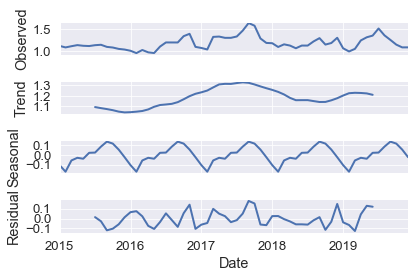

In [242]:

decomposition = seasonal_decompose(monthly_prices)
decomposition.plot()
plt.show()

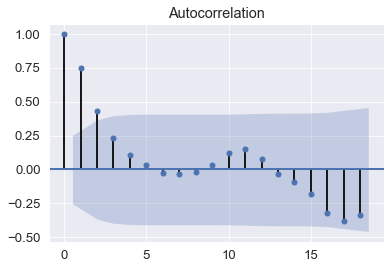

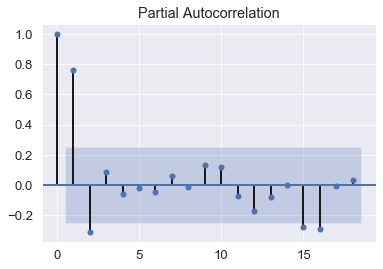

In [243]:
#Here we look at the autocorrelation and partial autocorrelation of the data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(monthly_prices)
plt.show()
plot_pacf(monthly_prices)
plt.show()

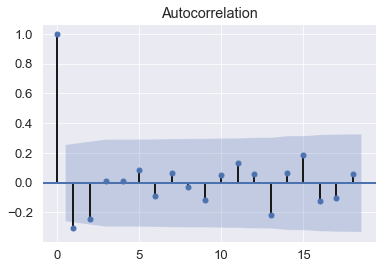

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



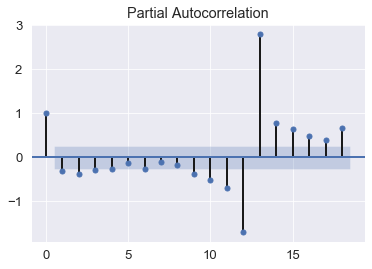

In [244]:
#Based on the above graph, we choose the twice difference
monthly_returns = monthly_prices.diff().diff().dropna()
plot_acf(monthly_returns)
plt.show()
plot_pacf(monthly_returns)
plt.show()

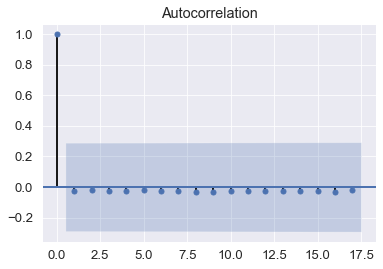

In [245]:
yearly_monthly_returns = monthly_returns.div(monthly_returns.shift(12)) - 1
plot_acf(yearly_monthly_returns.dropna())
plt.show()

#### Train test split

In [246]:
train_pct = 200/253
total_len = len(monthly_prices)
monthly_prices_train = monthly_prices.iloc[0:int(train_pct * total_len)]
monthly_prices_test = monthly_prices.iloc[int(train_pct * total_len):total_len]

## Define the SARIMAX model

#### Grid Search SARIMA Model Hyperparameters for Time Series Forecasting:
#### Non-seasonal components: p - Trend autoregression order; d - Trend difference order; q - Trend moving average order.


#### Seasonal components: P - Seasonal autoregressive order; D - Seasonal difference order; Q - Seasonal moving average order; m - The number of time steps for a single seasonal period.



In [247]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models

## Train the model

In [248]:
%%time

p = range(5)
q = range(5)
P = range(5)
Q = range(5)
d = 2
D = 1
s = 12
best_model_2diff = best_sarima_model(monthly_prices_train, p, q, P, Q, d, D, s)

Best model so far: SARIMA(0, 2, 0, 0, 1, 0, 12) AIC:-14.0 BIC:-13.0 HQIC:-14.0 resid:1.058


/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Best model so far: SARIMA(0, 2, 0, 1, 1, 0, 12) AIC:-22.0 BIC:-19.0 HQIC:-21.0 resid:1.05
Best model so far: SARIMA(0, 2, 1, 0, 1, 0, 12) AIC:-28.0 BIC:-25.0 HQIC:-27.0 resid:1.038
Best model so far: SARIMA(0, 2, 1, 1, 1, 0, 12) AIC:-37.0 BIC:-32.0 HQIC:-35.0 resid:1.032
Best model so far: SARIMA(0, 2, 1, 2, 1, 0, 12) AIC:-39.0 BIC:-33.0 HQIC:-37.0 resid:1.038


/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/bas



                                 Statespace Model Results                                 
Dep. Variable:                       AveragePrice   No. Observations:                   47
Model:             SARIMAX(0, 2, 1)x(2, 1, 0, 12)   Log Likelihood                  23.404
Date:                            Thu, 14 May 2020   AIC                            -38.808
Time:                                    14:15:57   BIC                            -32.821
Sample:                                01-31-2015   HQIC                           -36.793
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999    283.449     -0.004      0.997    -556.549     554.549
ar.S.L12      -0.8392      0.121 

/Users/liujing/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Evaluate the performance of the SARIMA model

#### Different from the LSTM models, SARIMA does not need input of the variable itself. All it needs is the timestamps at which you want to predict the values.

In [249]:
monthly_prices.index[-len(monthly_prices_test):]

DatetimeIndex(['2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31'],
              dtype='datetime64[ns]', name='Date', freq='M')

#### Predict

In [250]:
prediction = best_model_2diff[0].predict(start=monthly_prices.index[0],end=monthly_prices.index[-1]).iloc[2:]
test_prediction = prediction.iloc[-len(monthly_prices_test):]

In [251]:
prediction.head()

2015-03-31    1.045195
2015-04-30    1.134461
2015-05-31    1.156969
2015-06-30    1.101484
2015-07-31    1.104687
Freq: M, dtype: float64

#### Create a dataframe to store the prediction results

In [258]:
sarima_train_test_predict_df = pd.concat([monthly_prices_train, monthly_prices_test, prediction.loc[monthly_prices_test.index]], axis=1)
sarima_train_test_predict_df.columns = ['train', 'test', 'prediction']
#sarima_train_test_predict_df.plot()

In [ ]:
sarima_train_test_predict_df.to_csv('/Users/liujing/Desktop/Coursera/Captone/SARIMA_prediction_from_test_data.csv')

#### Calculate the evaluation metrics

In [253]:
#Evaluare the testset prediction

#MAE (mean absolute error)
import math
from sklearn.metrics import  mean_absolute_error, mean_squared_error
sarima_mae = mean_absolute_error(monthly_prices_test, prediction.loc[monthly_prices_test.index])
sarima_rmse = math.sqrt(mean_squared_error(monthly_prices_test, prediction.loc[monthly_prices_test.index]))



print('mae:',sarima_mae, ' SARIMA')
print('rmse:',sarima_rmse, ' SARIMA')

# OLD
# rmse_2diff_train = np.sqrt(best_model_2diff[0].resid[2:].pow(2).mean())
# rmse_2diff_test = np.sqrt(test_prediction.to_frame().rename(columns={0: 'AveragePrice'}).sub(monthly_prices_test).pow(2).mean())
# print(f'train rmse {rmse_2diff_train}')
# print(f'test rmse {rmse_2diff_test}')

mae: 0.158880184735778  SARIMA
rmse: 0.18568760740908033  SARIMA


In [257]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1,shared_xaxes=True,vertical_spacing=0.1,subplot_titles=("Stateful LSTM prediction from true test dataset mae: {mae_value:.3f}, rmse:{rmse_value:.3f}".format(mae_value=stateful_from_test_data_mae,rmse_value=stateful_from_test_data_rmse),
                                                   "Stateful LSTM prediction from predicted data mae: {mae_value:.3f}, rmse:{rmse_value:.3f}".format(mae_value=stateful_prediction_from_prediction_mae,rmse_value=stateful_prediction_from_prediction_rmse),
                                                   "Classical SARIMA mae:{mae_value:.3f}, rmse:{rmse_value:.3f}".format(mae_value=sarima_mae,rmse_value=sarima_rmse)))








fig.append_trace(go.Scatter(
    x=stateful_prediction_from_test_data_df.index,y=stateful_prediction_from_test_data_df['train'],
                   name='train',legendgroup='train',mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8), row=1, col=1)

fig.append_trace(go.Scatter(
    x=stateful_prediction_from_test_data_df.index,y=stateful_prediction_from_test_data_df['test'],
                   name='test',legendgroup='test',mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8), row=1, col=1)

fig.append_trace(go.Scatter(
    x=stateful_prediction_from_test_data_df.index,y=stateful_prediction_from_test_data_df['prediction'],
                   name='prediction',legendgroup='prediction',mode='lines+markers',marker=dict(
                                 color='rgb(249,249,11)',
                                 line=dict(
                                 color='rgb(158,158,14)',
                                 width=1.5)),
                                opacity=0.8,
                            hovertext=stateful_prediction_from_test_data_df.index), row=1, col=1)


fig.append_trace(go.Scatter(
    x=stateful_prediction_from_prediction_df.index,y=stateful_prediction_from_prediction_df['train'],
                   name='train',showlegend=False, mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8), row=2, col=1)

fig.append_trace(go.Scatter(
    x=stateful_prediction_from_prediction_df.index,y=stateful_prediction_from_prediction_df['test'],
                   name='test',showlegend=False, mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8), row=2, col=1)


fig.append_trace(go.Scatter(
    x=stateful_prediction_from_prediction_df.index,y=stateful_prediction_from_prediction_df['prediction'],
                   name='prediction',showlegend=False, mode='lines+markers',marker=dict(
                                 color='rgb(249,249,11)',
                                 line=dict(
                                 color='rgb(158,158,14)',
                                 width=1.5)),
                                opacity=0.8,
                            hovertext=stateful_prediction_from_prediction_df.index), row=2, col=1)



fig.append_trace(go.Scatter(
    x=sarima_train_test_predict_df.index,y=sarima_train_test_predict_df['train'],
                   name='train',showlegend=False,legendgroup='train',mode='lines+markers',marker=dict(
                                 color='rgb(158,202,225)',
                                 line=dict(
                                 color='rgb(8,48,107)',
                                 width=1.5)),
                                opacity=0.8), row=3, col=1)

fig.append_trace(go.Scatter(
    x=sarima_train_test_predict_df.index,y=sarima_train_test_predict_df['test'],
                   name='test',showlegend=False,legendgroup='test',mode='lines+markers',marker=dict(
                                 color='rgb(248,146,146)',
                                 line=dict(
                                 color='rgb(249,52,52)',
                                 width=1.5)),
                                opacity=0.8), row=3, col=1)

fig.append_trace(go.Scatter(
    x=sarima_train_test_predict_df.index,y=sarima_train_test_predict_df['prediction'],
                   name='prediction',showlegend=False,legendgroup='prediction',mode='lines+markers',marker=dict(
                                 color='rgb(249,249,11)',
                                 line=dict(
                                 color='rgb(158,158,14)',
                                 width=1.5)),
                                opacity=0.8,
                            hovertext=sarima_train_test_predict_df.index), row=3, col=1)

# Update xaxis properties
# fig.update_xaxes(title_text="Date", row=1, col=1)
# fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Average Price", row=1, col=1)
fig.update_yaxes(title_text="Average Price",  row=2, col=1)
fig.update_yaxes(title_text="Average Price",  row=3, col=1)



fig.update_layout(height=600, width=1000, title_text="Comparison between Stateful LSTM (two prediction methods) and SARIMA"
                  )



try:
    fig.show()
except:
    fig.show('svg')
# fig.show(renderer="colab")


# Inspiration beyond the scope of this project

#### We can zoom out by looking at the monthly averaged data instead of the weekly one.

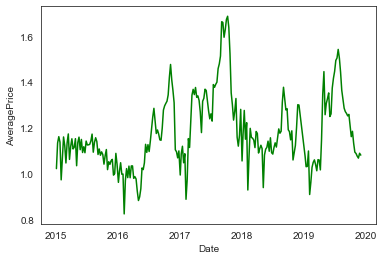

In [89]:
#Raw data: weekly data.
sns.lineplot(x=conventional_groupByDate.index,y='AveragePrice',data=conventional_groupByDate,color='green')


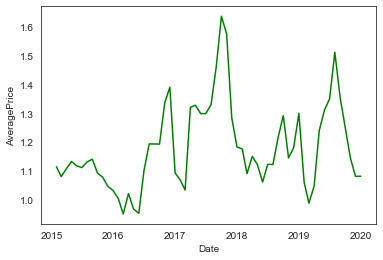

In [90]:
#If we look at a higher aggregation level of Month instead of Week. The time series looks like this.
#It appears that it has some seasonality with some trend across the year on top of it.
conventional_ByMonth = conventional_groupByDate.resample('M').mean()
sns.lineplot(x=conventional_ByMonth.index,y='AveragePrice',data=conventional_ByMonth,color='green')


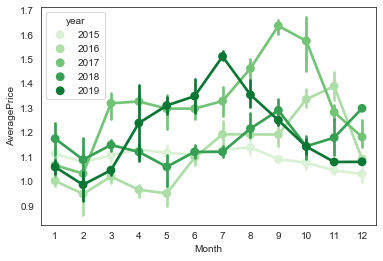

In [91]:
#To better view the seasonablity we can plot the monthly time series for each year.
sns.pointplot(data = conventional_groupByDate, x= 'Month', y='AveragePrice', hue='year', palette = 'Greens')